In [86]:
# Goal: Data preprocessing, NLP, topic models with LDA (MALLET, Gensim), visualization
# Result: implementations of topic models with high coherence scores from each library
# Output: pyLDAvis, wordcloud, csvs (document-topic, topic-document...)
# Resource: https://www.machinelearningplus.com/nlp/topic-modeling

# Helper libraries
import re
from pprint import pprint
import pandas as pd
import numpy as np

# Text pre-processing
import spacy
import nltk

# Topic modeling wrapper, coherence
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import wordcloud
from wordcloud import WordCloud

In [87]:
# DATA Read in docs (corpus) from csv; report length of abstract text
docs = pd.read_csv("data/ERI-combined-2009-2019.csv")
len(docs)

# Concatenate title and abstract to new column for topic model
docs['combined'] = docs['title'].astype(str) + ' ' + docs['abstract'].astype(str)
docs.head()

# Calculate lengths of combined title and abstract; add columns to dataframe for length of abstracts
docs['title_len'] = docs['title'].apply(len)
docs['abstract_len'] = docs['abstract'].apply(len)
docs['combined_len'] = docs['combined'].apply(len)
#docs.head()

# Calculate summary statistics for combined title and abstract lengths
docs.combined_len.describe()

count    3770.000000
mean     1678.432626
std       687.609548
min       128.000000
25%      1247.000000
50%      1630.000000
75%      1993.000000
max      7083.000000
Name: combined_len, dtype: float64

In [85]:
# DATA Title and abstract to list, removing new line characters, quotations
data = docs['combined'].values.tolist()
data = [re.sub('\s+', ' ', sent) for sent in data] #remove new line characters
data = [re.sub("\'", "", sent) for sent in data] #remove single quotes
pprint(data[:1])

['Streams and Urbanization Urbanization encompasses a diverse array of '
 'watershed alterations that influence the physical, chemical, and biological '
 'characteristics of streams. In this chapter, we summarize lessons learned '
 'from the last half century of research on urban streams and provide a '
 'critique of various mitigation strategies, including recent approaches that '
 'explicitly address geomorphic processes. We focus first on the abiotic '
 'conditions (primarily hydrologic and geomorphic) and their changes in '
 'streams that accompany urbanization, recognizing that these changes may vary '
 'with geomorphic context and climatic region. We then discuss technical '
 'approaches and limitations to (1) mitigating water-quantity and '
 'water-quality degradation through site design, riparian protection, and '
 'structural stormwater-management strategies; and (2) restoring urban streams '
 'in those watersheds where the economic, social, and political contexts can '
 'supp

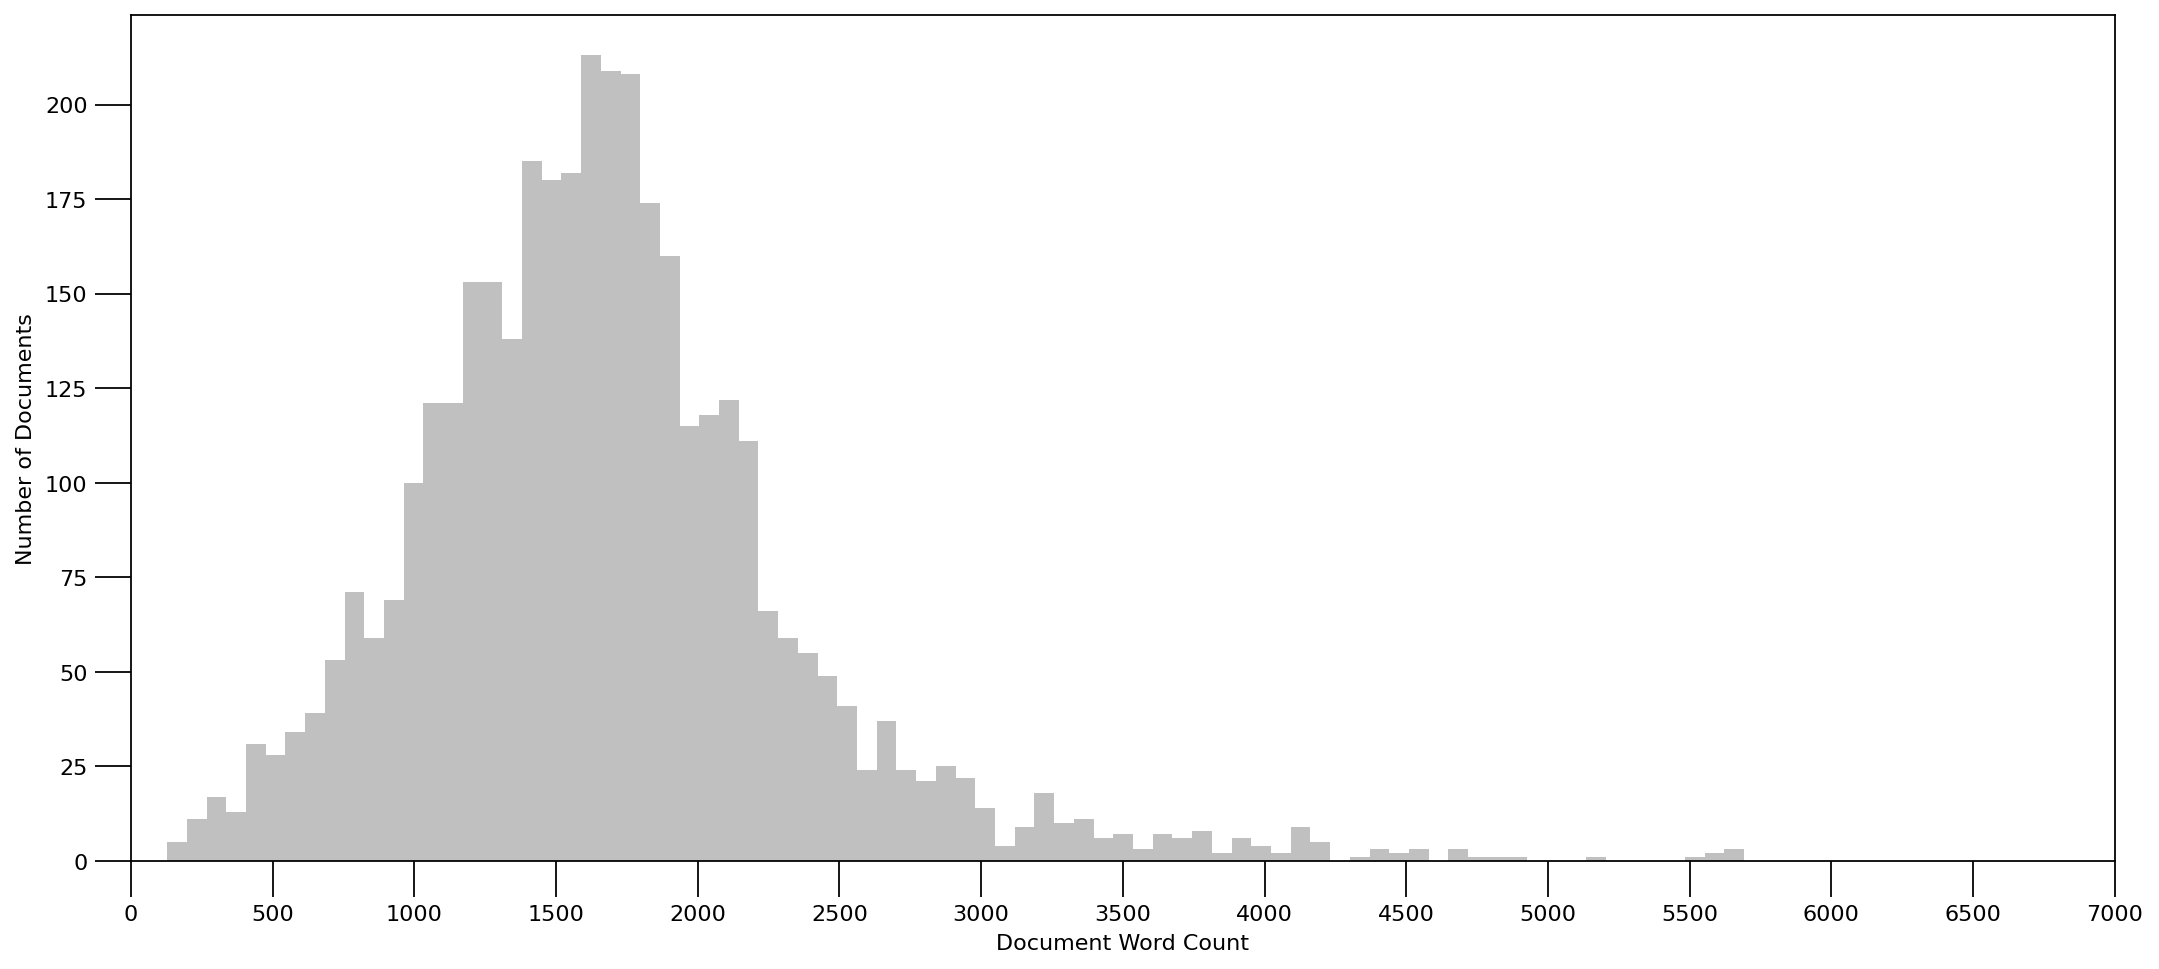

In [88]:
# DATA Frequency distribution of word counts in documents
doc_lens = [len(d) for d in docs.combined]

# Plot distribution of documents (titles & abstracts)
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 100, color='silver')
plt.gca().set(xlim=(0, 7000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,7000,15))
plt.show()
#plt.savefig('figures/word-count-dist.png')

In [83]:
# NLP Load stopwords from NLTK, extend default list with custom stopwords (from frequent terms)
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['data', 'study', 'project', 'research', 'collaborative', 'use', 
                   'include', 'result', 'increase', 'high', 'low', 'large', 'include', 'based'])

In [89]:
# NLP Tokenize each sentence into list of lowercase words, remove punctuation
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data))

print(data_words[:1])

[['streams', 'and', 'urbanization', 'urbanization', 'encompasses', 'diverse', 'array', 'of', 'watershed', 'alterations', 'that', 'influence', 'the', 'physical', 'chemical', 'and', 'biological', 'characteristics', 'of', 'streams', 'in', 'this', 'chapter', 'we', 'summarize', 'lessons', 'learned', 'from', 'the', 'last', 'half', 'century', 'of', 'research', 'on', 'urban', 'streams', 'and', 'provide', 'critique', 'of', 'various', 'mitigation', 'strategies', 'including', 'recent', 'approaches', 'that', 'explicitly', 'address', 'geomorphic', 'processes', 'we', 'focus', 'first', 'on', 'the', 'abiotic', 'conditions', 'primarily', 'hydrologic', 'and', 'geomorphic', 'and', 'their', 'changes', 'in', 'streams', 'that', 'accompany', 'urbanization', 'recognizing', 'that', 'these', 'changes', 'may', 'vary', 'with', 'geomorphic', 'context', 'and', 'climatic', 'region', 'we', 'then', 'discuss', 'technical', 'approaches', 'and', 'limitations', 'to', 'mitigating', 'water', 'quantity', 'and', 'water', 'qua

In [90]:
# NLP Bigram and trigram models (words frequently occurring together in the doc)
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=80) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[data_words], threshold=80)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See bigram example (given a specific record)
print(trigram_mod[bigram_mod[data_words[1]]])

['evidence', 'for', 'widespread', 'creep', 'on', 'the', 'flanks', 'of', 'the', 'sea', 'of', 'marmara', 'transform', 'basin', 'from', 'marine', 'geophysical', 'data', 'wave', 'fields', 'have', 'long', 'been', 'recognized', 'in', 'marine', 'sediments', 'on', 'the', 'flanks', 'of', 'basins', 'and', 'oceans', 'in', 'both', 'tectonically_active', 'and', 'inactive', 'environments', 'the', 'origin', 'of', 'waves', 'hereafter', 'called', 'undulations', 'is', 'controversial', 'competing', 'models', 'ascribe', 'them', 'to', 'depositional', 'processes', 'gravity', 'driven', 'downslope', 'creep', 'or', 'collapse', 'and', 'or', 'tectonic', 'shortening', 'here', 'we', 'analyze', 'pervasive', 'undulation', 'fields', 'identified', 'in', 'swath', 'bathymetry', 'and', 'new', 'high', 'resolution', 'multichannel_seismic', 'mcs', 'reflection', 'data', 'from', 'the', 'sea', 'of', 'marmara', 'turkey', 'although', 'they', 'exhibit', 'some', 'of', 'the', 'classical', 'features', 'of', 'sediment', 'waves', 'the

In [91]:
# NLP Define functions for stopwords, bigrams, trigrams, and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [92]:
# NLP Remove stopwords, make bigrams, make trigrams, and lemmatize
data_words_nostops = remove_stopwords(data_words) # stop words
data_words_bigrams = make_bigrams(data_words_nostops) # bigrams
data_words_trigrams = make_trigrams(data_words_bigrams) # trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['stream', 'urbanization', 'urbanization', 'encompass', 'diverse', 'array', 'watershed', 'alteration', 'influence', 'physical', 'chemical', 'biological', 'characteristic', 'stream', 'chapter', 'summarize', 'lessons_learn', 'last', 'half', 'century', 'urban', 'stream', 'provide', 'critique', 'various', 'mitigation', 'strategy', 'include', 'recent', 'approach', 'explicitly', 'address', 'geomorphic', 'process', 'focus', 'first', 'abiotic', 'condition', 'primarily', 'hydrologic', 'geomorphic', 'change', 'stream', 'accompany', 'urbanization', 'recognize', 'change', 'may', 'vary', 'geomorphic', 'context', 'climatic', 'region', 'discuss', 'technical', 'approach', 'limitation', 'mitigate', 'water', 'quantity', 'water', 'quality', 'degradation', 'site', 'design', 'riparian', 'protection', 'structural', 'stormwater', 'management', 'strategy', 'restore', 'urban', 'stream', 'watershed', 'economic', 'social', 'political', 'context', 'support', 'activity']]


In [93]:
# NLP Create dictionary and corpus for topic modeling
# Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View corpus based on term-frequency
#print(corpus[:1])
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Save dictionary and corpus for reuse - optional
#import pickle
#pickle.dump(corpus, open('outputs/LDA-corpus.pkl', 'wb'))
#id2word.save('outputs/LDA-dictionary.gensim')

[[('abiotic', 1),
  ('accompany', 1),
  ('activity', 1),
  ('address', 1),
  ('alteration', 1),
  ('approach', 2),
  ('array', 1),
  ('biological', 1),
  ('century', 1),
  ('change', 2),
  ('chapter', 1),
  ('characteristic', 1),
  ('chemical', 1),
  ('climatic', 1),
  ('condition', 1),
  ('context', 2),
  ('critique', 1),
  ('degradation', 1),
  ('design', 1),
  ('discuss', 1),
  ('diverse', 1),
  ('economic', 1),
  ('encompass', 1),
  ('explicitly', 1),
  ('first', 1),
  ('focus', 1),
  ('geomorphic', 3),
  ('half', 1),
  ('hydrologic', 1),
  ('include', 1),
  ('influence', 1),
  ('last', 1),
  ('lessons_learn', 1),
  ('limitation', 1),
  ('management', 1),
  ('may', 1),
  ('mitigate', 1),
  ('mitigation', 1),
  ('physical', 1),
  ('political', 1),
  ('primarily', 1),
  ('process', 1),
  ('protection', 1),
  ('provide', 1),
  ('quality', 1),
  ('quantity', 1),
  ('recent', 1),
  ('recognize', 1),
  ('region', 1),
  ('restore', 1),
  ('riparian', 1),
  ('site', 1),
  ('social', 1),
  

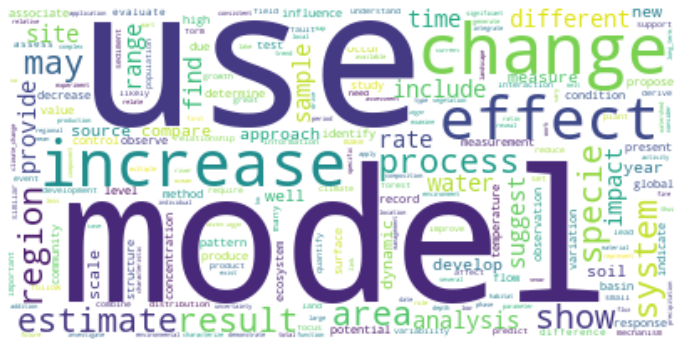

In [195]:
# NLP Display the lemmatized data with stopwords removed to see most frequent terms
flat_list = []
for sublist in texts: #flatten the list of lists from lemmatized texts in previous step
    for item in sublist:
        flat_list.append(item)

wordcloud = WordCloud(background_color='white').generate(' '.join(flat_list))
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
#plt.savefig('figures/wordcloud-cleaned-corpus.png')

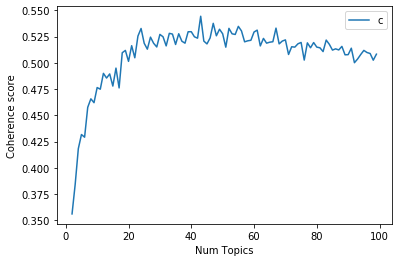

<Figure size 432x288 with 0 Axes>

In [22]:
# TOPIC MODELING (LDA) - MALLET, Find optimal number of topics for LDA (up to limit) 
# Approach: build many LDA models with different topic numbers (k); find the one with the highest coherence value
# Goal: choose an inflection point (k) that marks the end of a rapid growth of topic coherence

mallet_path = 'mallet-2.0.8/bin/mallet' # path to Mallet file in same directory
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Takes a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=100, step=1)

# Show graph
#plt.style.use("ggplot")
#matplotlib.rcParams.update({"font.size": 14})
#fig = plt.figure(figsize=(13,7))
#ax = plt.plot(x, coherence_values)
limit=100; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
#plt.savefig('figures/LDA-coherence-V2.png')

In [26]:
# TOPIC MODELING (LDA) - MALLET, Print the coherence scores from the previous run; select highest score (47 topics)
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3561
Num Topics = 3  has Coherence Value of 0.3842
Num Topics = 4  has Coherence Value of 0.4182
Num Topics = 5  has Coherence Value of 0.4317
Num Topics = 6  has Coherence Value of 0.4292
Num Topics = 7  has Coherence Value of 0.4576
Num Topics = 8  has Coherence Value of 0.4657
Num Topics = 9  has Coherence Value of 0.462
Num Topics = 10  has Coherence Value of 0.4764
Num Topics = 11  has Coherence Value of 0.4749
Num Topics = 12  has Coherence Value of 0.49
Num Topics = 13  has Coherence Value of 0.4855
Num Topics = 14  has Coherence Value of 0.4894
Num Topics = 15  has Coherence Value of 0.4779
Num Topics = 16  has Coherence Value of 0.495
Num Topics = 17  has Coherence Value of 0.4761
Num Topics = 18  has Coherence Value of 0.5096
Num Topics = 19  has Coherence Value of 0.5118
Num Topics = 20  has Coherence Value of 0.5014
Num Topics = 21  has Coherence Value of 0.5163
Num Topics = 22  has Coherence Value of 0.5048
Num Topics = 23  has Cohe

In [94]:
# TOPIC MODELING (LDA) - MALLET, Build a model with the highest coherence score (43 topics)
mallet_path = 'mallet-2.0.8/bin/mallet' # path to Mallet file in same directory
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus, 
                                             id2word=id2word, 
                                             num_topics=8,
                                             #optimize_interval=10,
                                             random_seed=1)

# Compute coherence score, verify that it is the same as in the previous run (higher is better)
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.47117432178383845


In [96]:
# OUTPUT - Topic, keyword, and keyword weight to CSV
top_words_per_topic = []
for t in range(ldamallet.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in ldamallet.show_topic(t, topn = 10)])
topic_keyword_weights = pd.DataFrame(top_words_per_topic, columns=['Topic', 'Keyword', 'Weight'])
#topic_keyword_weights.shape
#topic_keyword_weights.to_csv('outputs/LDA/LDA-8-topic-keyword-weights.csv')
#topic_keyword_weights.to_csv('outputs/LDA/LDA-43-topic-keyword-weights.csv')

In [98]:
# OUTPUT - Topic, keywords to CSV
topic_keyword_weights.drop(columns=['Weight'])
topic_keywords = topic_keyword_weights.groupby('Topic')['Keyword'].agg(lambda col: ', '.join(col))
df_topic_keywords = topic_keywords.to_frame()
#df_topic_keywords.shape
#df_topic_keywords.to_csv('outputs/LDA/LDA-8-topic-keywords.csv')
#df_topic_keywords.to_csv('outputs/LDA/LDA-43-topic-keywords.csv')

In [100]:
# OUTPUT - Document, dominant topic, percent contribution, keywords, text to CSV
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]): # dominant topic for each document
        row = sorted(row, key=lambda x: (x[1]), reverse=True) # dominant topic, percent contribution, and keywords
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), 
                                                                  topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)  # Add original text to the end of the output
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)
df_dominant_topic = df_topic_sents_keywords.reset_index() # Format as table
df_dominant_topic.columns = ['Document', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
#df_dominant_topic.shape
#df_dominant_topic.to_csv('outputs/LDA/LDA-8-document-topic.csv') #save to csv
#df_dominant_topic.to_csv('outputs/LDA/LDA-43-document-topic.csv') #save to csv

In [102]:
# OUTPUT - Document, topic weight matrix to CSV
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet) #transform MALLET model to Gensim LDA for use
topics = model.get_document_topics(corpus, per_word_topics=True) #store doc_topics for all the documents in the corpus
all_topics = [(doc_topics, word_topics, phi_values) for doc_topics, word_topics, phi_values in topics]

# doc_topics, word_topics, phi_values = all_topics[4] # as example, access details of doc 3
# print('Document topic:', doc_topics, "\n")
# print('Word topic:', word_topics, "\n")
# print('Phi value:', phi_values)

rows = [] 
for doc_topics, word_topics, phi_values in all_topics:
    rows.append([doc_topics, word_topics, phi_values])
topics_df = pd.DataFrame(rows, columns=['doc_topics', 'word_topics', 'phi_values'])
topics_df['Document'] = np.arange(len(topics_df))
topics_df.head()

result = pd.merge(df_dominant_topic, topics_df, on='Document', how='left', indicator=True) # join on 'Document' key
result_updated = result.drop(columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'word_topics', 'phi_values', '_merge', 'Text'])

document_topics = result_updated.doc_topics.to_list()
topics = sum(document_topics, [])
topics = set([topic[0] for topic in topics])
for i, document_topic in enumerate(document_topics):
    document_topic = dict(document_topic)
    document_topics[i] = []
    for topic in topics:
        document_topics[i].append(document_topic[topic] if topic in document_topic else 0)
columns = [f'topic_{i}' for i in topics]
df_new = pd.DataFrame(data=document_topics, columns=columns)

df_new.insert(0, 'Document', np.arange(len(df_new)))
df_new.head(10)
#df_new.shape
#df_new.to_csv('outputs/LDA/LDA-8-document-topic-weights.csv') #save out to csv
#df_new.to_csv('outputs/LDA/LDA-43-document-topic-weights.csv') #save out to csv

In [106]:
# OUTPUT - Document, title, text, topic, PIs (all) to CSV
# TO DO: fix PI name (first, last) formatting for project PIs (add delimiter to split)
docs.insert(0, 'Document', np.arange(len(docs)))
combined = pd.merge(docs, df_new, on='Document', how='left', indicator=True) # join on 'Document' key

pubs = pd.read_csv("data/ERI-publications-2009-2019.csv")
pubs.insert(0, 'Type', "publication")
pubs_renamed = pubs.rename(columns={"dim_title": "title", "Authors": "pis", "dim_description": "abstract"})
pubs_renamed.dtypes

proj = pd.read_csv("data/ERI-projects-2009-2019.csv")
proj.insert(0, 'Type', "project")
proj.head() #fields to get: Type, title, start-year, end-year, pis
proj.dtypes

df_concat = pd.concat([pubs_renamed, proj], sort=False)
df_merge = pd.merge(df_concat, combined, on='title', how='left') # join on 'title' key
#for col in df_merge.columns: print(col) 
    
df_merge_updated = df_merge.drop(columns = ['id_x', 'Rank', 'dim_type', 'Publication ID', 'dim_url', 'PMID', 'PMCID', 'Title', 'Anthology title', 'MeSH terms', 'Publication Date', 'Volume', 'Issue', 'Pagination', 'Open Access', 'Publication Type',  'Corresponding Author', 'Authors Affiliations', 'Times cited', 'dimensions_title', 'dimensions_description', 'dimensions_type', 'dimensions_url', 'Recent citations', 'RCR', 'FCR', 'Source Linkout', 'Dimensions URL', 'FOR 1', 'FOR 2', 'FOR 3', 'FOR 4', 'FOR 5', 'start', 'end', 'id_y', 'title_len', 'abstract_len', 'combined_len', '_merge', 'abstract_x'])
df_merge_updated.dtypes
df_dropped = df_merge_updated.dropna(how='any', subset=['Document'])# drop records without Document id
df_dropped.set_index('Document')
df_dropped = df_dropped[['Document','title','abstract_y','combined', 'pis', 'DOI', 'Source title', 'PubYear', 'FOR (ANZSRC) Categories', 'filename', 'amount', 'agency', 'relationship', 'id.1', 'start-year', 'end-year', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7']] 
                         #,'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'topic_32', 'topic_33', 'topic_34', 'topic_35', 'topic_36', 'topic_37', 'topic_38', 'topic_39', 'topic_40', 'topic_41', 'topic_42']]
df_renamed = df_dropped.rename(columns={"Document": "document", "abstract_y": "abstract", "Source title": "source_title", "PubYear": "publication_year", "FOR (ANZSRC) Categories": "for_categories", "id.1": "project_id", "start-year": "start_year", "end-year": "end_year"})
df_sorted = df_renamed.sort_values(by=['document'])

reshaped = \
(df_sorted.set_index(df_sorted.columns.drop('pis',1).tolist())
   .pis.str.split('; ', expand=True) #split PI column by ;
   .stack()
   .reset_index()
   .rename(columns={0:'pis'})
   .loc[:, df_sorted.columns]
)
reshaped[['Last_Name', 'First_Name']] = reshaped.pis.str.split(",",expand=True)
reshaped['Last_Name'] = reshaped['Last_Name'].str.strip()
#reshaped.shape
#reshaped.to_csv('outputs/LDA/LDA-8-document-topic-pis.csv') #save out to csv
#reshaped.to_csv('outputs/LDA/LDA-43-document-topic-pis.csv') #save out to csv

In [108]:
# OUTPUT - PIs (ERI publications only) topics with topic weights
# TO DO: re-run with fixed PI names to include project topics
eri_pis = pd.read_csv("data/ERI-people-2009-2019.csv")
pis_merged = pd.merge(eri_pis, reshaped, on='Last_Name', how='inner', indicator=True) # join on 'Last_Name' key
#pis_merged.shape
#pis_merged.to_csv('outputs/LDA/LDA-8-pi-topics.csv') #save out to csv
#pis_merged.to_csv('outputs/LDA/LDA-43-pi-topics.csv') #save out to csv

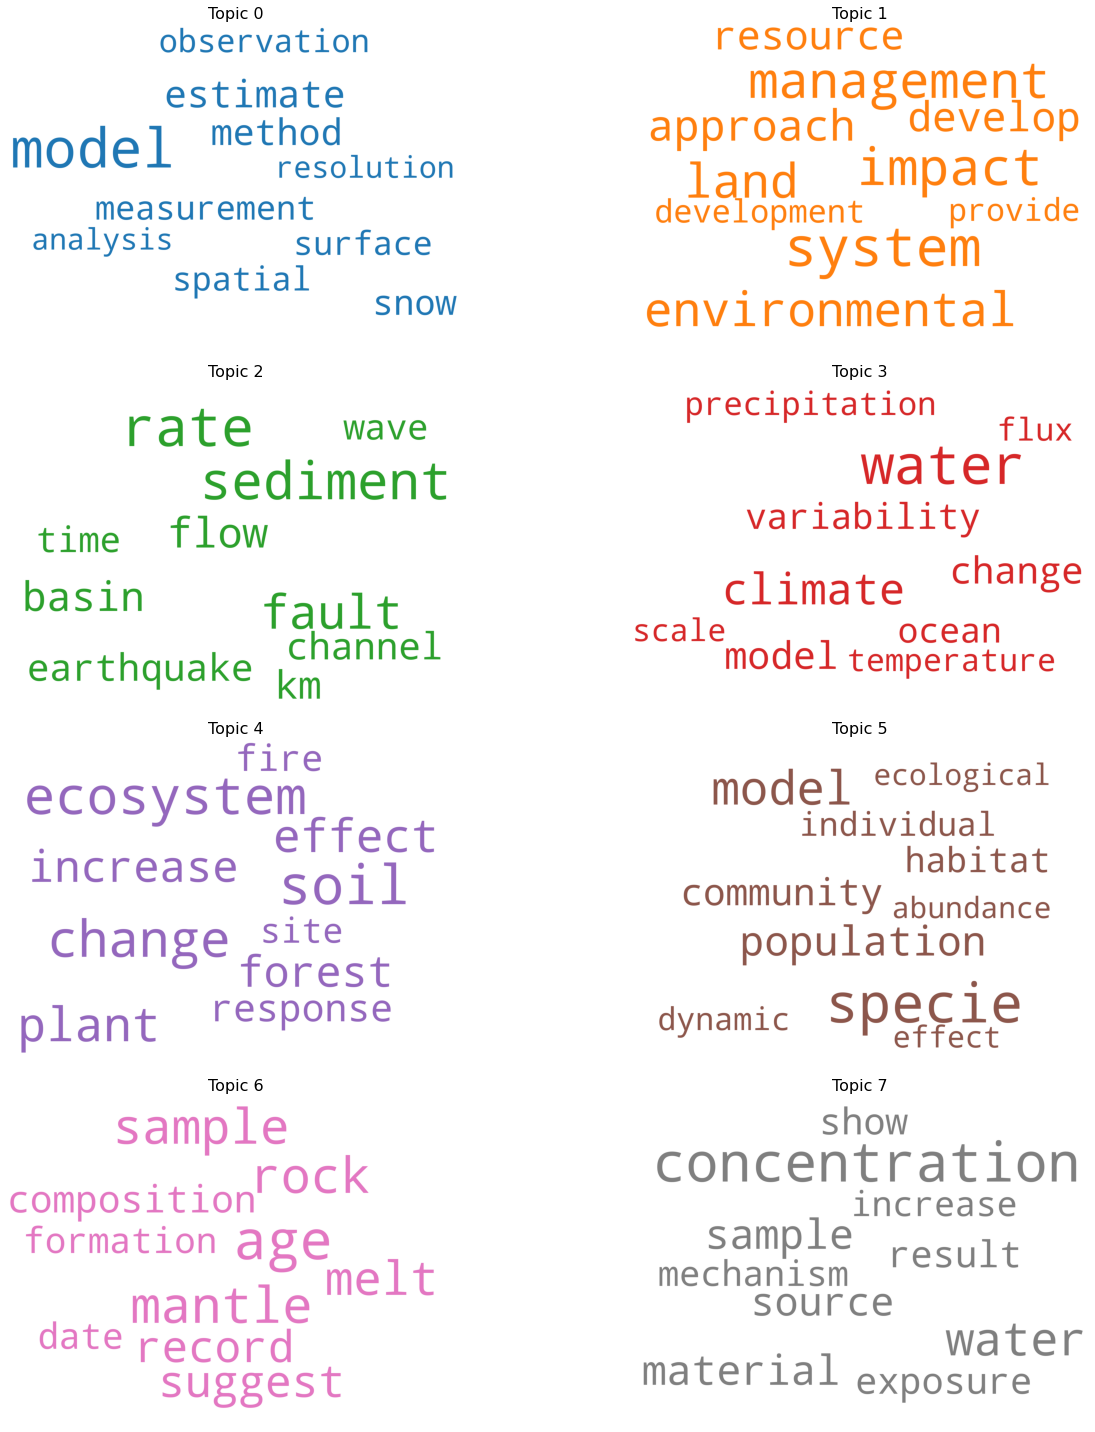

In [112]:
# VISUALIZATION - Wordcloud of top N words in each topic
# TO DO: visualize all topic wordclouds (beyond first 10)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = model.show_topics(num_topics=-1, num_words=10, formatted=False) #uses the converted Gensim model
#topics = ldamallet.show_topics(formatted=False) #uses the MALLET model
#pprint(topics) #see tuple structure of topics [(topic), [('keyword', 'weight'), ('keyword', 'weight')...]]

fig, axes = plt.subplots(4, 2, figsize=(20,20), sharex=True, sharey=True)
#fig, axes = plt.subplots(5, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    #print(topic_words)
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16)) #topic numbers are incorrect (instead check print(topics) and print(topic_words))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
#plt.savefig('figures/LDA-mallet-8-word-clouds.png') #exports graphic
#plt.savefig('figures/LDA-mallet-43-word-clouds.png') #exports graphic

In [114]:
# VISUALIZATION - Topic model interface with pyLDAvis
# TO DO: offset topic numbers by 1 to match model exactly
#model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet) #convert Mallet model into a LdaModel
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word, sort_topics=False) #match topic order to Gensim model
pyLDAvis.save_html(vis, 'outputs/LDA/lda-mallet-8.html') #save pyLDAvis graph as standalone webpage
#pyLDAvis.save_html(vis, 'outputs/LDA/lda-mallet-43.html') #save pyLDAvis graph as standalone webpage
vis

/Users/saralafia/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/saralafia/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/saralafia/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.114520 -0.191419       1        1  12.751742
1      0.234408 -0.180303       2        1  13.508386
2     -0.205821 -0.078388       3        1  12.761788
3     -0.105364  0.165512       4        1  13.143708
4      0.049169  0.278728       5        1  12.378340
5      0.111890  0.088345       6        1  11.878539
6     -0.292257 -0.128617       7        1  12.353836
7      0.093457  0.046141       8        1  11.223661, topic_info=          Term         Freq        Total Category  logprob  loglift
120      model  4458.000000  4458.000000  Default  30.0000  30.0000
64       water  2761.000000  2761.000000  Default  29.0000  29.0000
227     specie  1794.000000  1794.000000  Default  28.0000  28.0000
912       soil  1410.000000  1410.000000  Default  27.0000  27.0000
802  ecosystem  1332.000000  1332.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
886    observe   212.609634   575.176996   Topic8  -5.5906   1.1919
680     method   242.982439  1064.774636   Topic8  -5.4571   0.7096
261     effect   265.762043  1697.000828   Topic8  -5.3674   0.3331
214  potential   215.863863   942.004580   Topic8  -5.5754   0.7138
514    surface   220.202836  1722.397324   Topic8  -5.5555   0.1302

[741 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
2777       6  1.000521  abundance
9441       2  0.976384  accounted
1619       1  0.999278   accuracy
638        1  0.998145   accurate
154        3  0.760693     active
...      ...       ...        ...
1169       5  0.005561      young
1169       7  0.995491      young
25831      7  0.928733     zeolit
635        7  0.999719     zircon
1073       8  1.002744        zno

[1044 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
# VISUALIZATION - Interactive plotly chart